In [2]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import pandas as pd 
import csv
import itertools
from sklearn.metrics import roc_auc_score,  precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import time


import os
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
from dgl import graph 
from dgl.nn import GraphConv, SAGEConv, RelGraphConv
# from dgl.convert import from_networkx
import dgl.function as fn
from dgl.data import DGLDataset


import torch
import torch.nn as nn
import torch.nn.functional as F

Approach : generating negative triples and framing the task of link prediction as a classification problem where the model is trained to distinguiqh betweeen positive triples

In [2]:
# with open(file_path, 'r', encoding='utf-8') as fin, open(cleaned_triples, 'w', encoding='utf-8') as fout:
#     for line in fin:
#         parts = line.strip().split('\t')
#         if len(parts) == 3:
#             entity1, relation, entity2 = parts
#             if entity1.startswith('http://www.wikidata.org/entity/Q') and relation.startswith('http://www.wikidata.org/prop/direct/P') and entity2.startswith('http://www.wikidata.org/entity/Q'):
#                 qid1 = entity1.split('/')[-1]
#                 pid = relation.split('/')[-1]
#                 qid2 = entity2.split('/')[-1]
#                 fout.write(f"{qid1}\t{pid}\t{qid2}\n")

In [3]:
# # construct some csv to create a dataset with nodes and edges features

# with open(cleaned_triples, 'r') as f:
#     reader = csv.reader(f, delimiter='\t')
#     triples = [line for line in reader]


# entities = set()
# for s, p, o in triples:
#     entities.add(s)
#     entities.add(o)

# entity_to_id = {entity: idx for idx, entity in enumerate(sorted(entities))}


# edges = []
# for s, p, o in triples:
#     src_id = entity_to_id[s]
#     dest_id = entity_to_id[o]
#     edges.append([src_id, dest_id, p])


# with open('entities.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Id', 'Jid'])
#     for entity, idx in entity_to_id.items():
#         writer.writerow([idx, entity])

# with open('props.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Src', 'Dest', 'Property'])
#     for edge in edges:
#         writer.writerow(edge)

In [8]:
# artworks = pd.read_csv("./PyG_data/entities.csv")
artworks = pd.read_csv("./PyG_data/artworks_augmented.csv")
properties = pd.read_csv("./PyG_data/props.csv")
artworks.head(), properties.head()
artworks.columns, properties.columns

(Index(['Id', 'Jid', 'entity', 'label'], dtype='object'),
 Index(['Src', 'Dest', 'Prop'], dtype='object'))

In [9]:
# unique_values = artworks['Jid'].unique()
# all_results = []


# formatted_elements = [f'wd:{element}' for element in unique_values]


# batch_size = 500 


# sparql = SPARQLWrapper("https://query.wikidata.org/sparql")


# def execute_query(sparql, query):
#     sparql.setQuery(query)
#     sparql.setReturnFormat(JSON)
#     sparql.setMethod(POST)  
#     results = sparql.query().convert()
#     return results


# for i in range(0, len(formatted_elements), batch_size):
#     batch = formatted_elements[i:i + batch_size]
#     values_str = " ".join(batch)

    
#     query = f"""
#     PREFIX wd: <http://www.wikidata.org/entity/>
#     PREFIX wikibase: <http://wikiba.se/ontology#>
#     PREFIX bd: <http://www.bigdata.com/rdf#>

#     SELECT ?entity ?entityLabel WHERE {{
#       VALUES ?entity {{ {values_str} }}
#       SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
#     }}
#     """
#     try:
#         results = execute_query(sparql, query)
#         for result in results["results"]["bindings"]:
#             entity = result["entity"]["value"]
#             label = result["entityLabel"]["value"]
#             all_results.append({'entity': entity, 'label': label})

#             print(f"{entity}: {label}")
#     except Exception as e:
#         print(f"An error occurred: {e}")
    
   
#     time.sleep(1)

# print("Batch processing complete.")

In [10]:
# df = pd.DataFrame(all_results)

# df.to_csv('./PyG_data/wikidata_entity_labels.csv', index=False)

In [11]:
# artworks_labels = pd.read_csv('./PyG_data/wikidata_entity_labels.csv' )
# artworks_labels['Jid'] = artworks_labels['entity'].str.split('/').str[-1]
# artworks_labels

# artworks_augmented = pd.merge(artworks, artworks_labels, on='Jid', how='left')

# # artworks_augmented.to_csv('./PyG_data/artworks_augmented.csv', index=0)

# artworks_augmented.head()

In [12]:
property_mapping = {prop: idx for idx, prop in enumerate(properties["Prop"].unique())}
properties["Prop_ID"] = properties["Prop"].map(property_mapping)

In [13]:
class ArtworksDataset(DGLDataset):
    def __init__(self):
        super().__init__(name="Artworks")

    def process(self):
        
        nodes_data = artworks
        # node_features = torch.from_numpy(nodes_data["artwork_label"].astype("category").cat.codes.to_numpy(copy=True)).long() 
        node_features = torch.arange(nodes_data.shape[0]).long() #each node will have a unique integer as its feature
        
        edges_data = properties
        property_mapping = {prop: idx for idx, prop in enumerate(edges_data["Prop"].unique())}
        edges_data["Prop_ID"] = edges_data["Prop"].map(property_mapping)
        edges_src = torch.from_numpy(edges_data["Src"].to_numpy())
        edges_dst = torch.from_numpy(edges_data["Dest"].to_numpy())
        edge_features = torch.from_numpy(edges_data["Prop_ID"].to_numpy()).long()  # Use Prop_ID
        
        self.graph = dgl.graph(
            (edges_src, edges_dst), num_nodes=nodes_data.shape[0]
        )
        self.graph.ndata["feat"] = node_features
        self.graph.edata["type"] = edge_features
        
        # Masks handling for link prediction task
        n_edges = edges_data.shape[0]
        n_train = int(n_edges * 0.6)
        n_val = int(n_edges * 0.2)
        train_mask = torch.zeros(n_edges, dtype=torch.bool)
        val_mask = torch.zeros(n_edges, dtype=torch.bool)
        test_mask = torch.zeros(n_edges, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train : n_train + n_val] = True
        test_mask[n_train + n_val :] = True
        self.graph.edata["train_mask"] = train_mask
        self.graph.edata["val_mask"] = val_mask
        self.graph.edata["test_mask"] = test_mask
        
        
    def __getitem__(self, i):
        return self.graph
    def __len__(self):
        return 1


    

In [14]:
dataset = ArtworksDataset()
g = dataset[0]

g

Graph(num_nodes=32153, num_edges=217178,
      ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'type': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})

In [15]:
print(g.edata.keys()) 
print(g.ndata.keys()) 

dict_keys(['type', 'train_mask', 'val_mask', 'test_mask'])
dict_keys(['feat'])


In [59]:
class GraphSAGE(nn.Module):
    def __init__(self, num_nodes, embed_size, h_feats):
        super(GraphSAGE, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embed_size) 
        self.conv1 = SAGEConv(embed_size, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.embedding(in_feat) #convert node index into a vector representation in a higher-dimensional space
        h = self.conv1(g, h) 
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


In [60]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():  # context manager provided by DGL that ensures any modifications to the graph g are local to this block of code
            g.ndata["h"] = h
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            return g.edata["score"][:, 0]


In [ ]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)


In [61]:
u, v = g.edges()
eids = np.arange(g.num_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.num_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(g.num_nodes(), g.num_nodes()))
adj_neg = 1 - adj.todense() - np.eye(g.num_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.num_edges(), replace=False)
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)

In [ ]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [ ]:
# train_g.ndata["feat"] = g.ndata["feat"]
# train_g.ndata["feat"].shape[0]
# train_g.num_edges

In [ ]:
# train_pos_eids = torch.tensor(eids[test_size:])
# test_pos_eids = torch.tensor(eids[:test_size])

In [ ]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.num_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.num_nodes())

train_pos_g.edata['type'] = g.edata['type'][eids[test_size:]]
train_neg_g.edata['type'] = g.edata['type'][eids[test_size:]]


test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.num_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.num_nodes())

test_pos_g.edata['type'] = g.edata['type'][eids[:test_size]]
test_neg_g.edata['type'] = g.edata['type'][eids[:test_size]]

In [ ]:
train_pos_g.edata.keys() 

dict_keys([])

In [24]:
num_nodes = g.num_nodes()
embed_size = 16  
h_feats = 128  

model = GraphSAGE(num_nodes, embed_size, h_feats)
predictor = DotPredictor()

# g.ndata["feat"] = torch.arange(num_nodes).long()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

edge feature ( type of predicate /prop)?
the scoring function ( needs to be relational
)

In [24]:
def train_model(model, predictor, optimizer, train_g, train_pos_g, train_neg_g, num_epochs=100):
    pbar = tqdm(total=num_epochs, desc="Training", unit="epoch")
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        h = model(train_g, train_g.ndata["feat"])# node rep update
        
        pos_scores = predictor(train_pos_g, h)  #computes scores for each edge (between src and dest nodes) in train_pos_g based on node embed h.
        neg_scores = predictor(train_neg_g, h)
        
        loss = compute_loss(pos_scores, neg_scores)
        
        loss.backward()
    
        optimizer.step()
        pbar.update(1)
        pbar.set_postfix({"Loss": loss.item()})

    pbar.close()




In [25]:
train_model(model, predictor, optimizer, train_g, train_pos_g, train_neg_g, num_epochs=200)


Training: 100%|██████████| 200/200 [00:10<00:00, 18.20epoch/s, Loss=0.288]


In [26]:
model.eval()
with torch.no_grad():
    h = model(g, g.ndata["feat"])
    pos_score = predictor(test_pos_g, h)
    neg_score = predictor(test_neg_g, h)
    auc = compute_auc(pos_score, neg_score)
    print(f'AUC: {auc}')

AUC: 0.8550195936272998


Optimal threshold: 1.293473720550537


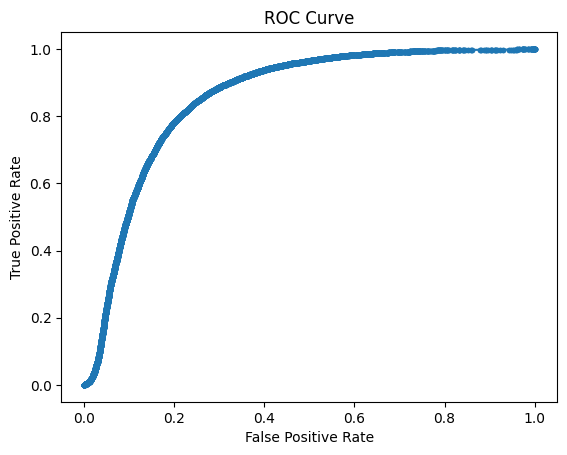

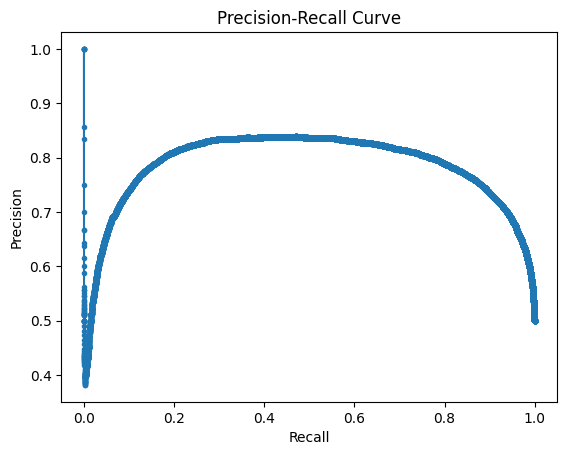

In [27]:
scores = np.concatenate([pos_score, neg_score])
labels = np.concatenate([np.ones(len(pos_score)), np.zeros(len(neg_score))])

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Print the optimal threshold
print(f'Optimal threshold: {optimal_threshold}')

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate and plot precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(labels, scores)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

 select threshold where the difference between TPR and FPR is the greatest. which s heuristic to find a threshold that balances sensitivity(recall) and specificity (where the model maximizes the true positives while minimizing the false positives)

In [28]:
def predict_edge(model, pred, g, head_idx, tail_idx):
    
    head_features = g.ndata['feat'][head_idx]
    tail_features = g.ndata['feat'][tail_idx]

    h = model(g, g.ndata['feat'])

    single_edge_g = dgl.graph(([head_idx], [tail_idx]), num_nodes=g.num_nodes())
    
    score = pred(single_edge_g, h)

    edge_exists = score.item() > 1.1353756189346313

    return score.item(), edge_exists


In [29]:
head_idx ,tail_idx= 14203  , 5890
score= predict_edge(model, predictor, g, head_idx, tail_idx)
print(f"Score for edge between {head_idx} and {tail_idx}: {score}")


Score for edge between 14203 and 5890: (-4.634915828704834, False)


In [30]:
pair_exists = not properties[((properties['Src'] == head_idx) & (properties['Dest'] == tail_idx) | (properties['Src'] == tail_idx) & (properties['Dest'] == head_idx))].empty
pair_exists


False

In [31]:
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# }, 'SAGE_model_1.pth')


#### relational GNN class

In [38]:
class RGCN(nn.Module):
    def __init__(self, num_nodes, embed_size, num_rels, hidden_size):
        super(RGCN, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embed_size)
        self.conv1 = RelGraphConv(embed_size, hidden_size, num_rels, regularizer="basis", num_bases=10)
        self.conv2 = RelGraphConv(hidden_size, hidden_size, num_rels, regularizer="basis", num_bases=10)

    def forward(self, g, in_feat, etypes):
        h = self.embedding(in_feat)
        h = F.relu(self.conv1(g, h, etypes))
        h = F.relu(self.conv2(g, h, etypes))
        return h

In [39]:
class TransEPredictor(nn.Module):
    def __init__(self, embedding_dim):
        super(TransEPredictor, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, head_embed, relation_embed, tail_embed):
        score = -torch.norm(head_embed + relation_embed - tail_embed, p=2, dim=1)
        return score

In [40]:
num_rels = g.edata["type"].max().item() + 1 
embed_size = 64
hidden_size = 128
num_rels

111

In [41]:
model_RGCN = RGCN(num_nodes, embed_size, num_rels, hidden_size)
transE_predictor = TransEPredictor(embed_size)

optimizer = torch.optim.Adam(list(model_RGCN.parameters()) + list(transE_predictor.parameters()), lr=0.005)

In [42]:
train_g.edata.keys()

dict_keys(['type', 'train_mask', 'val_mask', 'test_mask'])

In [45]:
#train RGCN_Model
for epoch in range(100):
    model_RGCN.train()
    optimizer.zero_grad()
    
    h = model_RGCN(train_g, train_g.ndata["feat"], train_g.edata["type"]) 
    
    pos_head_embed = h[train_pos_g.edges()[0]]
    pos_tail_embed = h[train_pos_g.edges()[1]]
    pos_relation_embed = model_RGCN.embedding(train_pos_g.edata["type"]) 

    neg_head_embed = h[train_neg_g.edges()[0]]
    neg_tail_embed = h[train_neg_g.edges()[1]]
    neg_relation_embed = model_RGCN.embedding(train_neg_g.edata["type"]) 
    
    pos_scores = transE_predictor(pos_head_embed, pos_relation_embed, pos_tail_embed)
    neg_scores = transE_predictor(neg_head_embed, neg_relation_embed, neg_tail_embed)
    
    loss = compute_loss(pos_scores, neg_scores)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')


KeyError: 'type'

next implemetations :
* explore with more encoder layers (IT IS RELATIONAL DATA )
* explore with more embedding models as predictor 
 ### What about edge type : the property the relation represents


Approach 2 : reframe the prediction part so we could query the model in such way (h, r, ?) and it returns all tail entites that make the triple valid 
or query like (h, ? , t ) and return the relation (we assume it exists)

In [16]:
class RGCN(nn.Module):
    def __init__(self, num_nodes, h_dim, num_rels):
        super(RGCN, self).__init__()
        self.embed = nn.Embedding(num_nodes, h_dim)
        self.conv1 = RelGraphConv(h_dim, h_dim, num_rels, "basis", num_bases=5)
        self.conv2 = RelGraphConv(h_dim, h_dim, num_rels, "basis", num_bases=5)

    def forward(self, g, etypes):
        h = self.embed.weight
        h = self.conv1(g, h, etypes)
        h = torch.relu(h)
        h = self.conv2(g, h, etypes)
        return h


In [17]:
class DistMultDecoder(nn.Module):
    def __init__(self, h_dim, num_rels):
        super(DistMultDecoder, self).__init__()
        self.relation_emb = nn.Embedding(num_rels, h_dim)

    def forward(self, h, triplets):
        src, rel, dst = triplets[:, 0], triplets[:, 1], triplets[:, 2]
        src_emb = h[src]
        rel_emb = self.relation_emb[rel]
        dst_emb = h[dst]
        score = (src_emb * rel_emb * dst_emb).sum(dim=1)
        return score

In [18]:
num_nodes = g.number_of_nodes()
num_rels = len(property_mapping)

rgcn_model = RGCN(num_nodes, 16, num_rels)
decoder = DistMultDecoder(16, num_rels)

In [20]:
def get_triplets(g, mask):
    edges = g.edges(order='eid')
    src, dst = edges[0][mask], edges[1][mask]
    rel = g.edata['type'][mask]
    return torch.stack((src, rel, dst), dim=1)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
    return nn.BCEWithLogitsLoss()(scores, labels)

In [19]:
optimizer = torch.optim.Adam(list(rgcn_model.parameters()) + list(decoder.parameters()), lr=0.01)

In [21]:
for epoch in range(100):
    rgcn_model.train()
    h = rgcn_model(g, g.edata['type'])
    pos_triplets = get_triplets(g, g.edata['train_mask'])
    neg_triplets = torch.stack((pos_triplets[:, 0], torch.randint(0, num_rels, (pos_triplets.size(0),)), pos_triplets[:, 2]), dim=1)
    pos_score = decoder(h, pos_triplets)
    neg_score = decoder(h, neg_triplets)

    loss = compute_loss(pos_score, neg_score)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        rgcn_model.eval()
        with torch.no_grad():
            val_triplets = get_triplets(g, g.edata['val_mask'])
            val_neg_triplets = torch.stack((val_triplets[:, 0], torch.randint(0, num_rels, (val_triplets.size(0),)), val_triplets[:, 2]), dim=1)
            val_pos_score = decoder(h, val_triplets)
            val_neg_score = decoder(h, val_neg_triplets)
            val_loss = compute_loss(val_pos_score, val_neg_score)
        print(f'Epoch {epoch} | Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}')


TypeError: 'Embedding' object is not subscriptable